In [415]:
import pandas as pd
import matplotlib.pyplot as plt

data_path = "./data_sets/"

df_patients= pd.read_csv(data_path + 'PATIENTS.csv.gz')        
df_admissions = pd.read_csv(data_path + 'ADMISSIONS.csv.gz')        
df_icustays = pd.read_csv(data_path + 'ICUSTAYS.csv.gz')     
df_diagnoses = pd.read_csv(data_path + 'DIAGNOSES_ICD.csv.gz', low_memory=False) 


In [416]:
# Filter for Pneumonia (ICD-9 = 48283)
df_target = df_diagnoses[df_diagnoses['ICD9_CODE'] == '48283'][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']]

print(df_target.shape)
df_target.head()

(264, 3)


,SUBJECT_ID,HADM_ID,ICD9_CODE
38,114,178393,48283
4202,339,112625,48283
5063,285,165312,48283
7541,605,115545,48283
8075,720,171046,48283


In [417]:
df_admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [418]:
# Merge with admissions to get LOS
df_merged = pd.merge(
    df_target,
    df_admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ETHNICITY']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)
print(df_merged.shape)
df_merged.head()

(264, 5)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,ETHNICITY
0,114,178393,48283,2146-08-29 01:18:00,UNKNOWN/NOT SPECIFIED
1,339,112625,48283,2187-04-20 23:10:00,BLACK/AFRICAN AMERICAN
2,285,165312,48283,2152-09-21 22:47:00,HISPANIC OR LATINO
3,605,115545,48283,2197-11-09 12:59:00,ASIAN
4,720,171046,48283,2160-02-15 21:44:00,WHITE


In [419]:
df_icustays.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [420]:
# Merge with ICU stays (if any)
df_merged = pd.merge(
    df_merged,
    df_icustays[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'INTIME', 'LOS']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'

)

df_merged.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,ETHNICITY,ICUSTAY_ID,INTIME,LOS
0,114,178393,48283,2146-08-29 01:18:00,UNKNOWN/NOT SPECIFIED,258626,2146-08-29 17:59:00,1.8132
1,339,112625,48283,2187-04-20 23:10:00,BLACK/AFRICAN AMERICAN,221278,2187-04-20 23:10:50,31.7018
2,285,165312,48283,2152-09-21 22:47:00,HISPANIC OR LATINO,238023,2152-09-21 22:48:50,28.6880
3,605,115545,48283,2197-11-09 12:59:00,ASIAN,248569,2197-11-09 13:00:45,16.8598
4,720,171046,48283,2160-02-15 21:44:00,WHITE,261862,2160-02-15 21:45:04,48.9253


In [421]:
df_patients.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [422]:
# Add patient demographics (optional)
df_merged = pd.merge(
    df_merged,
    df_patients[['SUBJECT_ID', 'GENDER', 'DOB']],
    on='SUBJECT_ID',
    how='left'
)

df_merged.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,ETHNICITY,ICUSTAY_ID,INTIME,LOS,GENDER,DOB
0,114,178393,48283,2146-08-29 01:18:00,UNKNOWN/NOT SPECIFIED,258626,2146-08-29 17:59:00,1.8132,M,2098-05-09 00:00:00
1,339,112625,48283,2187-04-20 23:10:00,BLACK/AFRICAN AMERICAN,221278,2187-04-20 23:10:50,31.7018,F,2120-07-17 00:00:00
2,285,165312,48283,2152-09-21 22:47:00,HISPANIC OR LATINO,238023,2152-09-21 22:48:50,28.6880,M,2107-05-16 00:00:00
3,605,115545,48283,2197-11-09 12:59:00,ASIAN,248569,2197-11-09 13:00:45,16.8598,F,1895-04-05 00:00:00
4,720,171046,48283,2160-02-15 21:44:00,WHITE,261862,2160-02-15 21:45:04,48.9253,F,2108-08-25 00:00:00


In [423]:
df_merged.isnull().sum()

SUBJECT_ID    0
HADM_ID       0
ICD9_CODE     0
ADMITTIME     0
ETHNICITY     0
ICUSTAY_ID    0
INTIME        0
LOS           0
GENDER        0
DOB           0
dtype: int64

In [424]:
df_merged['DOB'] = pd.to_datetime(df_merged['DOB'])
df_merged['INTIME'] = pd.to_datetime(df_merged['INTIME'])

df_merged['ADMITTIME'] = pd.to_datetime(df_merged['ADMITTIME'])

# Correctly subtract the years
df_merged['AGE'] = (
    (df_merged['INTIME'].dt.year - df_merged['DOB'].dt.year) + 
    (df_merged['INTIME'].dt.dayofyear - df_merged['DOB'].dt.dayofyear) / 365.25
)
# Time since admitted in the hospital
df_merged['ADMITIME'] = (
    (df_merged['INTIME'].dt.year - df_merged['ADMITTIME'].dt.year) + 
    (df_merged['INTIME'].dt.dayofyear - df_merged['ADMITTIME'].dt.dayofyear) / 365.25
)

# Can drop DOB, INTIME and ADMITE TIME
df_merged.drop(columns=['DOB', 'ADMITTIME'], inplace=True)

df_merged.loc[df_merged['AGE'] > 89, 'AGE'] = 91.4  # Handle MIMIC-III's >89 group

df_merged = df_merged[df_merged['LOS'] > 1]

df_merged = df_merged.nsmallest(len(df_merged), 'LOS')  # Remove 2 max LOS rows   

unique_ethnicities = df_merged['ETHNICITY'].unique()
print(unique_ethnicities)

ethnicity_counts = df_merged['ETHNICITY'].value_counts()
print(ethnicity_counts)

df_merged.head()

['WHITE' 'UNKNOWN/NOT SPECIFIED' 'BLACK/AFRICAN AMERICAN' 'OTHER'
 'HISPANIC/LATINO - PUERTO RICAN' 'UNABLE TO OBTAIN' 'ASIAN'
 'HISPANIC OR LATINO' 'WHITE - RUSSIAN' 'HISPANIC/LATINO - DOMINICAN'
 'ASIAN - CHINESE' 'PATIENT DECLINED TO ANSWER']
ETHNICITY
WHITE                             216
BLACK/AFRICAN AMERICAN             28
UNKNOWN/NOT SPECIFIED              22
HISPANIC OR LATINO                  7
OTHER                               6
ASIAN                               5
UNABLE TO OBTAIN                    4
PATIENT DECLINED TO ANSWER          3
HISPANIC/LATINO - PUERTO RICAN      2
WHITE - RUSSIAN                     2
HISPANIC/LATINO - DOMINICAN         1
ASIAN - CHINESE                     1
Name: count, dtype: int64


,SUBJECT_ID,HADM_ID,ICD9_CODE,ETHNICITY,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,ADMITIME
287,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.000000
291,94937,162005,48283,UNKNOWN/NOT SPECIFIED,280084,2107-01-18 11:11:21,1.1432,M,68.389459,0.066393
244,63941,126602,48283,UNKNOWN/NOT SPECIFIED,270748,2196-04-23 14:49:48,1.1496,F,74.917864,0.002738
14,3078,147024,48283,WHITE,272986,2175-12-09 15:03:51,1.1541,M,47.793977,0.021903
29,5062,123244,48283,WHITE,250261,2100-12-10 12:50:48,1.2110,M,71.835044,0.027379


In [425]:
# List rare ethnicities (adjust threshold as needed)
rare_ethnicities = ['HISPANIC/LATINO - PUERTO RICAN', 'WHITE - RUSSIAN', 
                    'HISPANIC/LATINO - DOMINICAN', 'ASIAN - CHINESE',
                    'UNABLE TO OBTAIN', 'PATIENT DECLINED TO ANSWER']

# Consolidate
df_merged['ETHNICITY'] = df_merged['ETHNICITY'].replace(rare_ethnicities, 'OTHER')
df_merged.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE,ETHNICITY,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,ADMITIME
287,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.000000
291,94937,162005,48283,UNKNOWN/NOT SPECIFIED,280084,2107-01-18 11:11:21,1.1432,M,68.389459,0.066393
244,63941,126602,48283,UNKNOWN/NOT SPECIFIED,270748,2196-04-23 14:49:48,1.1496,F,74.917864,0.002738
14,3078,147024,48283,WHITE,272986,2175-12-09 15:03:51,1.1541,M,47.793977,0.021903
29,5062,123244,48283,WHITE,250261,2100-12-10 12:50:48,1.2110,M,71.835044,0.027379


In [426]:
from sklearn.preprocessing import LabelEncoder


gender_encoder = LabelEncoder()

df_merged['GENDER'] = gender_encoder.fit_transform(df_merged['GENDER'])

print("Gender Classes:", gender_encoder.classes_)

df_merged = pd.get_dummies(
    df_merged, 
    columns=['ETHNICITY'], 
    prefix='ETH',
    drop_first=True
    )

print(df_merged.isnull().sum())

df_merged.head()

Gender Classes: ['F' 'M']
SUBJECT_ID                    0
HADM_ID                       0
ICD9_CODE                     0
ICUSTAY_ID                    0
INTIME                        0
LOS                           0
GENDER                        0
AGE                           0
ADMITIME                      0
ETH_BLACK/AFRICAN AMERICAN    0
ETH_HISPANIC OR LATINO        0
ETH_OTHER                     0
ETH_UNKNOWN/NOT SPECIFIED     0
ETH_WHITE                     0
dtype: int64


,SUBJECT_ID,HADM_ID,ICD9_CODE,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,ADMITIME,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE
287,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.000000,False,False,False,False,True
291,94937,162005,48283,280084,2107-01-18 11:11:21,1.1432,1,68.389459,0.066393,False,False,False,True,False
244,63941,126602,48283,270748,2196-04-23 14:49:48,1.1496,0,74.917864,0.002738,False,False,False,True,False
14,3078,147024,48283,272986,2175-12-09 15:03:51,1.1541,1,47.793977,0.021903,False,False,False,False,True
29,5062,123244,48283,250261,2100-12-10 12:50:48,1.2110,1,71.835044,0.027379,False,False,False,False,True


In [427]:
df_ascending = df_merged.sort_values('LOS', ascending=True)
print("Top 5 Shortest LOS:")
# print(df_ascending[['SUBJECT_ID', 'HADM_ID','ICUSTAY_ID', 'LOS', 'INTIME', 'OUTTIME', 'age']].head())
df_ascending

Top 5 Shortest LOS:


,SUBJECT_ID,HADM_ID,ICD9_CODE,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,ADMITIME,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE
287,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.000000,False,False,False,False,True
291,94937,162005,48283,280084,2107-01-18 11:11:21,1.1432,1,68.389459,0.066393,False,False,False,True,False
244,63941,126602,48283,270748,2196-04-23 14:49:48,1.1496,0,74.917864,0.002738,False,False,False,True,False
14,3078,147024,48283,272986,2175-12-09 15:03:51,1.1541,1,47.793977,0.021903,False,False,False,False,True
29,5062,123244,48283,250261,2100-12-10 12:50:48,1.2110,1,71.835044,0.027379,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,22818,188392,48283,241236,2111-12-02 22:51:37,55.6687,0,73.405202,0.000000,True,False,False,False,False
138,21312,150854,48283,213825,2181-12-07 22:32:52,55.6920,0,76.547570,0.000000,False,False,False,False,True
53,7085,106726,48283,283819,2111-05-30 03:02:26,60.7469,0,42.027379,0.000000,False,False,False,False,True
106,16025,155705,48283,285837,2149-05-02 21:47:26,75.7236,0,57.125941,0.054757,False,False,False,False,True


In [428]:
df_descending = df_merged.sort_values('LOS', ascending=False)
print("\nTop 5 Longest LOS:")
# print(df_descending[['SUBJECT_ID', 'HADM_ID','ICUSTAY_ID', 'LOS', 'age']].head())
df_descending


Top 5 Longest LOS:


,SUBJECT_ID,HADM_ID,ICD9_CODE,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,ADMITIME,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE
43,6702,157559,48283,220172,2129-06-09 16:18:26,84.0409,1,80.644079,0.142368,False,False,False,False,True
106,16025,155705,48283,285837,2149-05-02 21:47:26,75.7236,0,57.125941,0.054757,False,False,False,False,True
53,7085,106726,48283,283819,2111-05-30 03:02:26,60.7469,0,42.027379,0.000000,False,False,False,False,True
138,21312,150854,48283,213825,2181-12-07 22:32:52,55.6920,0,76.547570,0.000000,False,False,False,False,True
140,22818,188392,48283,241236,2111-12-02 22:51:37,55.6687,0,73.405202,0.000000,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,5062,123244,48283,250261,2100-12-10 12:50:48,1.2110,1,71.835044,0.027379,False,False,False,False,True
14,3078,147024,48283,272986,2175-12-09 15:03:51,1.1541,1,47.793977,0.021903,False,False,False,False,True
244,63941,126602,48283,270748,2196-04-23 14:49:48,1.1496,0,74.917864,0.002738,False,False,False,True,False
291,94937,162005,48283,280084,2107-01-18 11:11:21,1.1432,1,68.389459,0.066393,False,False,False,True,False


In [429]:
df_merged.shape

(297, 14)

In [430]:
df_merged.describe().T

,count,mean,min,25%,50%,75%,max,std
SUBJECT_ID,297.0,33261.646465,114.0,11235.0,25474.0,48885.0,99715.0,28691.288358
HADM_ID,297.0,150159.565657,100395.0,125313.0,152457.0,174041.0,199845.0,27653.607582
ICUSTAY_ID,297.0,252482.037037,200387.0,231111.0,253774.0,275954.0,299728.0,28313.81701
INTIME,297,2150-07-19 20:50:48.461279232,2100-12-10 12:50:48,2124-03-21 23:14:40.999999488,2150-04-21 13:05:23.000000512,2174-08-18 19:05:27.000000512,2207-12-13 20:57:20,NaN
LOS,297.0,15.918696,1.1159,5.1157,12.6697,21.8292,84.0409,13.684957
GENDER,297.0,0.643098,0.0,0.0,1.0,1.0,1.0,0.479894
AGE,297.0,65.326929,19.350445,57.378508,68.054757,76.865845,91.4,15.921112
ADMITIME,297.0,0.01297,0.0,0.0,0.0,0.005476,0.468172,0.042997


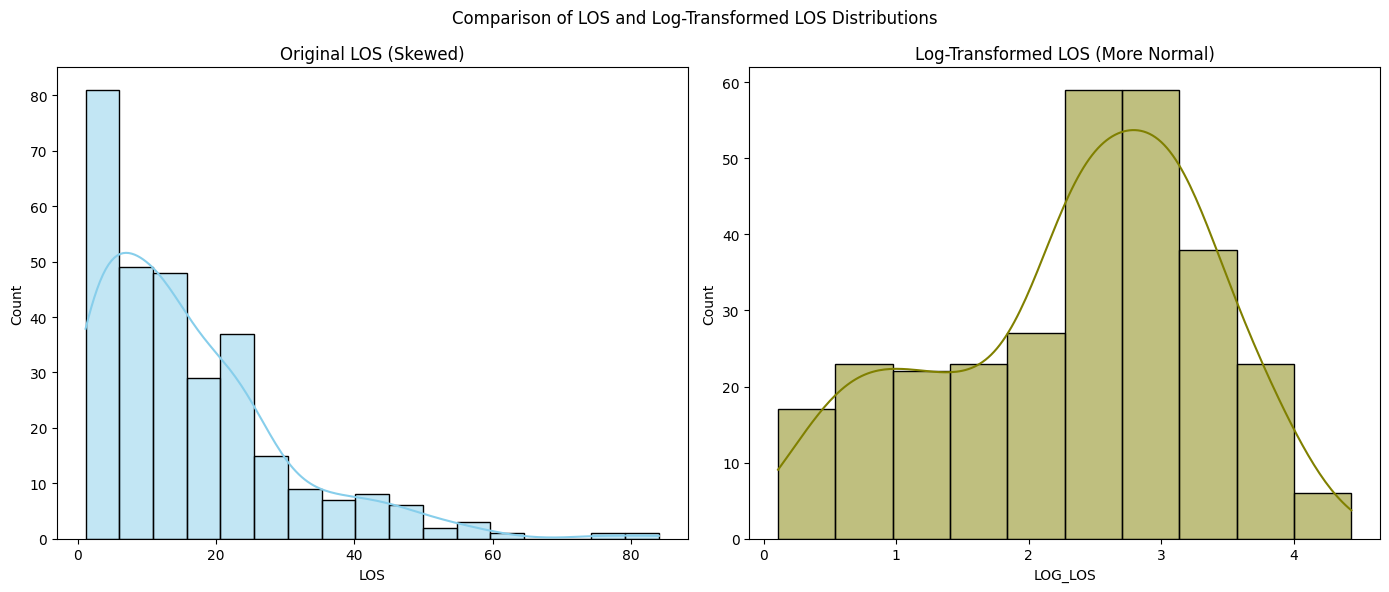

In [431]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_merged['LOG_LOS'] = np.log(df_merged['LOS'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Comparison of LOS and Log-Transformed LOS Distributions')

sns.histplot(df_merged['LOS'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Original LOS (Skewed)')

sns.histplot(df_merged['LOG_LOS'], kde=True, ax=axes[1], color='olive')
axes[1].set_title('Log-Transformed LOS (More Normal)')

plt.tight_layout()
plt.show()

In [432]:
# selected_small_id = 220271
# selected_mean_id =  284345
selected_big_id = 285837

icu_info = df_icustays[df_icustays['ICUSTAY_ID'] == selected_big_id]
icu_info


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
24829,20284,16025,155705,285837,carevue,TSICU,MICU,14,50,2149-05-02 21:47:26,2149-07-17 15:09:22,75.7236


In [433]:
starttime = pd.to_datetime(icu_info['INTIME'].iloc[0])
endtime = starttime + pd.Timedelta(hours=24)

starttime, endtime


(Timestamp('2149-05-02 21:47:26'), Timestamp('2149-05-03 21:47:26'))

In [434]:
print(df_merged.shape)
df_merged.head()

(297, 15)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,ADMITIME,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE,LOG_LOS
287,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.000000,False,False,False,False,True,0.109661
291,94937,162005,48283,280084,2107-01-18 11:11:21,1.1432,1,68.389459,0.066393,False,False,False,True,False,0.133831
244,63941,126602,48283,270748,2196-04-23 14:49:48,1.1496,0,74.917864,0.002738,False,False,False,True,False,0.139414
14,3078,147024,48283,272986,2175-12-09 15:03:51,1.1541,1,47.793977,0.021903,False,False,False,False,True,0.143321
29,5062,123244,48283,250261,2100-12-10 12:50:48,1.2110,1,71.835044,0.027379,False,False,False,False,True,0.191446


In [435]:
# df_chart_events =  pd.read_csv(data_path + 'chart_events_bronchitis.csv', low_memory=False)
df_chart_events =  pd.read_csv(data_path + 'd_pneumonia.csv', low_memory=False) 
 
print(df_chart_events.shape)      
df_chart_events.head()
# df_merged = pd.merge(df_merged, df_chart_events, how='inner')

# df_merged

(986962, 15)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,170754,1709,127294,207018,220052,2118-01-04 12:15:00,2118-01-04 14:22:00,19783.0,124.0,124.0,mmHg,0.0,0.0,NaN,NaN
1,170755,1709,127294,207018,220210,2118-01-04 12:15:00,2118-01-04 14:22:00,19783.0,30.0,30.0,insp/min,0.0,0.0,NaN,NaN
2,170756,1709,127294,207018,220277,2118-01-04 12:15:00,2118-01-04 14:22:00,19783.0,96.0,96.0,%,0.0,0.0,NaN,NaN
3,170757,1709,127294,207018,220179,2118-01-04 12:20:00,2118-01-04 14:22:00,19783.0,148.0,148.0,mmHg,0.0,0.0,NaN,NaN
4,170758,1709,127294,207018,220180,2118-01-04 12:20:00,2118-01-04 14:22:00,19783.0,69.0,69.0,mmHg,0.0,0.0,NaN,NaN


In [436]:
# 1. Merge df_merged with CHARTEVENTS (left join to preserve all ICU stays)
df_merged_with_chartevents = pd.merge(
    df_merged,  # Key columns
    df_chart_events[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'VALUENUM','CHARTTIME','VALUEUOM']].drop_duplicates(),
    on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'],
    how='left',
    indicator=True  # Adds a column '_merge' to show match status
)
# print(df_merged.columns)
# print(df_merged.shape)

# 2. Identify ICU stays with/without CHARTEVENTS
has_chartevents = df_merged_with_chartevents['_merge'] == 'both'
no_chartevents = df_merged_with_chartevents['_merge'] == 'left_only'

# 3. Get the lists of ICUSTAY_IDs
icu_with_data = df_merged_with_chartevents[has_chartevents]['ICUSTAY_ID'].unique()
icu_without_data = df_merged_with_chartevents[no_chartevents]['ICUSTAY_ID'].unique()

print(f"ICU stays WITH CHARTEVENTS data: {len(icu_with_data)}")
print(f"ICU stays WITHOUT CHARTEVENTS data: {len(icu_without_data)}")

df_merged_with_chartevents.head()

ICU stays WITH CHARTEVENTS data: 140
ICU stays WITHOUT CHARTEVENTS data: 157


,SUBJECT_ID,HADM_ID,ICD9_CODE,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,ADMITIME,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE,LOG_LOS,ITEMID,VALUENUM,CHARTTIME,VALUEUOM,_merge
0,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,False,False,False,False,True,0.109661,220277.0,94.0,2142-05-02 15:19:00,%,both
1,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,False,False,False,False,True,0.109661,223751.0,160.0,2142-05-02 15:19:00,mmHg,both
2,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,False,False,False,False,True,0.109661,223752.0,90.0,2142-05-02 15:19:00,mmHg,both
3,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,False,False,False,False,True,0.109661,223761.0,98.0,2142-05-02 15:19:00,?F,both
4,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,False,False,False,False,True,0.109661,223769.0,100.0,2142-05-02 15:19:00,%,both


<Axes: xlabel='NORMTIME', ylabel='Count'>

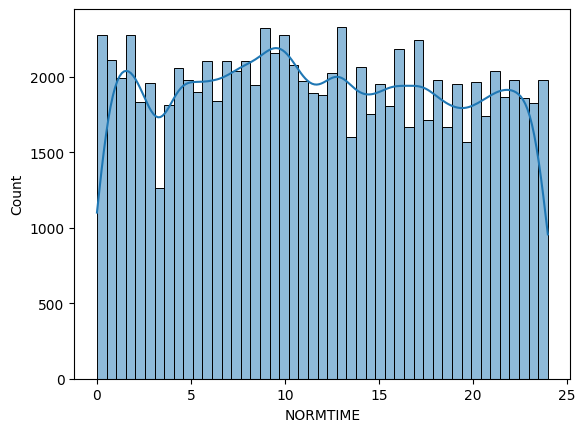

In [437]:
df_merged_with_chartevents['INTIME'] = pd.to_datetime(df_merged_with_chartevents['INTIME'])
df_merged_with_chartevents['CHARTTIME'] = pd.to_datetime(df_merged_with_chartevents['CHARTTIME'])

df_merged_with_chartevents.isnull().sum()

df_merged_with_chartevents['NORMTIME'] = (df_merged_with_chartevents['CHARTTIME'] - df_merged_with_chartevents['INTIME']).dt.total_seconds() / 3600
df_merged_with_chartevents = df_merged_with_chartevents[(df_merged_with_chartevents['NORMTIME'] < 24) &
                                                         (df_merged_with_chartevents['NORMTIME'] > 0)]
df_merged_with_chartevents.describe()
sns.histplot(df_merged_with_chartevents['NORMTIME'], kde=True)

<Axes: xlabel='NORMTIME', ylabel='Count'>

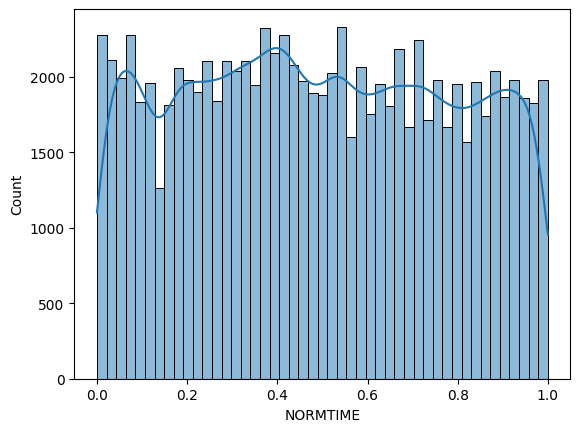

In [438]:
df_merged_with_chartevents['NORMTIME'] = df_merged_with_chartevents['NORMTIME'] / 24.0

sns.histplot(df_merged_with_chartevents['NORMTIME'], kde=True)

In [439]:
icu_with_data

array([243965, 280084, 270748, 210014, 200612, 285353, 284497, 201921,
       271827, 213653, 258626, 251009, 289137, 287844, 232180, 238731,
       274960, 265851, 202274, 275598, 251586, 203754, 248514, 239944,
       276330, 270331, 230391, 216379, 289186, 213339, 277618, 286609,
       295195, 241689, 275530, 234233, 223435, 232142, 202786, 231855,
       268113, 298668, 291479, 273636, 238708, 285599, 254293, 258212,
       216695, 278100, 210160, 296298, 240714, 291691, 254474, 254093,
       217440, 217726, 276468, 257533, 200387, 277323, 256557, 270380,
       270240, 247111, 277079, 214087, 299321, 200696, 264601, 241032,
       258054, 243197, 201667, 262172, 274718, 214175, 259979, 278016,
       293675, 231719, 231717, 269593, 254214, 280339, 249469, 215264,
       279995, 230131, 219048, 236989, 299407, 213159, 271393, 273705,
       226191, 248569, 282753, 293738, 243478, 241783, 244528, 292713,
       251832, 274326, 288087, 295935, 212945, 235268, 212116, 228565,
      

In [440]:
df_merged_with_chartevents.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE', 'ICUSTAY_ID', 'INTIME', 'LOS',
       'GENDER', 'AGE', 'ADMITIME', 'ETH_BLACK/AFRICAN AMERICAN',
       'ETH_HISPANIC OR LATINO', 'ETH_OTHER', 'ETH_UNKNOWN/NOT SPECIFIED',
       'ETH_WHITE', 'LOG_LOS', 'ITEMID', 'VALUENUM', 'CHARTTIME', 'VALUEUOM',
       '_merge', 'NORMTIME'],
      dtype='object')

<Axes: xlabel='AGE', ylabel='Count'>

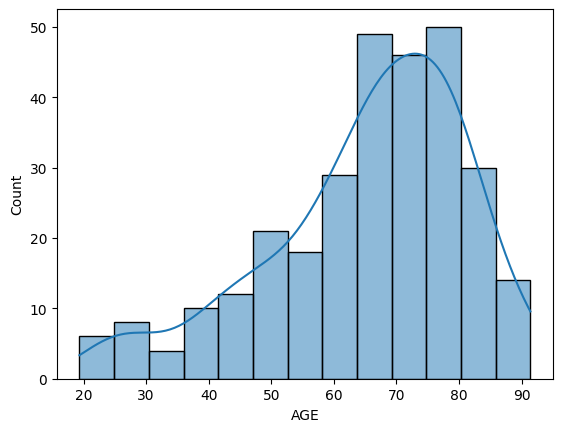

In [441]:
sns.histplot(df_merged['AGE'], kde=True)

In [442]:
df_merged.describe().T

,count,mean,min,25%,50%,75%,max,std
SUBJECT_ID,297.0,33261.646465,114.0,11235.0,25474.0,48885.0,99715.0,28691.288358
HADM_ID,297.0,150159.565657,100395.0,125313.0,152457.0,174041.0,199845.0,27653.607582
ICUSTAY_ID,297.0,252482.037037,200387.0,231111.0,253774.0,275954.0,299728.0,28313.81701
INTIME,297,2150-07-19 20:50:48.461279232,2100-12-10 12:50:48,2124-03-21 23:14:40.999999488,2150-04-21 13:05:23.000000512,2174-08-18 19:05:27.000000512,2207-12-13 20:57:20,NaN
LOS,297.0,15.918696,1.1159,5.1157,12.6697,21.8292,84.0409,13.684957
GENDER,297.0,0.643098,0.0,0.0,1.0,1.0,1.0,0.479894
AGE,297.0,65.326929,19.350445,57.378508,68.054757,76.865845,91.4,15.921112
ADMITIME,297.0,0.01297,0.0,0.0,0.0,0.005476,0.468172,0.042997
LOG_LOS,297.0,2.350774,0.109661,1.632314,2.539213,3.083249,4.431304,1.006111


In [443]:
print(df_merged_with_chartevents.shape)
# df_merged_with_chartevents.drop(columns=['_merge','INTIME','CHARTTIME'],inplace=True)

df_merged_with_chartevents.head()

(92007, 21)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,ADMITIME,ETH_BLACK/AFRICAN AMERICAN,...,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE,LOG_LOS,ITEMID,VALUENUM,CHARTTIME,VALUEUOM,_merge,NORMTIME
0,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,False,...,False,False,True,0.109661,220277.0,94.0,2142-05-02 15:19:00,%,both,0.010903
1,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,False,...,False,False,True,0.109661,223751.0,160.0,2142-05-02 15:19:00,mmHg,both,0.010903
2,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,False,...,False,False,True,0.109661,223752.0,90.0,2142-05-02 15:19:00,mmHg,both,0.010903
3,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,False,...,False,False,True,0.109661,223761.0,98.0,2142-05-02 15:19:00,?F,both,0.010903
4,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,False,...,False,False,True,0.109661,223769.0,100.0,2142-05-02 15:19:00,%,both,0.010903


In [444]:
df_merged_with_chartevents.describe().T

,count,mean,min,25%,50%,75%,max,std
SUBJECT_ID,92007.0,70275.763475,114.0,52901.0,89223.0,89223.0,99715.0,27342.750886
HADM_ID,92007.0,145898.83123,101117.0,134966.0,134966.0,166373.0,198412.0,23387.6077
ICUSTAY_ID,92007.0,268558.793614,200387.0,247111.0,280339.0,293675.0,299407.0,30362.824025
INTIME,92007,2171-11-03 15:21:13.437892608,2101-01-19 04:08:52,2147-04-17 04:20:43.000000512,2190-02-07 00:14:31.000000512,2197-08-08 13:36:31.000000512,2207-12-13 20:57:20,NaN
LOS,92007.0,13.419453,1.1159,10.0869,13.137,13.3291,48.9253,7.83178
GENDER,92007.0,0.357864,0.0,0.0,0.0,1.0,1.0,0.479374
AGE,92007.0,68.02055,21.366872,64.744695,72.778234,72.778234,91.4,12.555766
ADMITIME,92007.0,0.004702,0.0,0.0,0.0,0.0,0.158795,0.016746
LOG_LOS,92007.0,2.406832,0.109661,2.311238,2.575433,2.58995,3.890295,0.68807
ITEMID,92007.0,218334.806308,39.0,220181.0,223834.0,224695.0,228444.0,31439.136106


In [445]:
df_merged_with_chartevents.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE', 'ICUSTAY_ID', 'INTIME', 'LOS',
       'GENDER', 'AGE', 'ADMITIME', 'ETH_BLACK/AFRICAN AMERICAN',
       'ETH_HISPANIC OR LATINO', 'ETH_OTHER', 'ETH_UNKNOWN/NOT SPECIFIED',
       'ETH_WHITE', 'LOG_LOS', 'ITEMID', 'VALUENUM', 'CHARTTIME', 'VALUEUOM',
       '_merge', 'NORMTIME'],
      dtype='object')

In [446]:
static_features = df_merged_with_chartevents.drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'])[
    ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID','ADMITIME', 'AGE', 'GENDER', 
     'ETH_BLACK/AFRICAN AMERICAN', 'ETH_HISPANIC OR LATINO', 
     'ETH_OTHER', 'ETH_UNKNOWN/NOT SPECIFIED', 'ETH_WHITE', 'LOG_LOS']
]

static_features.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ADMITIME,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE,LOG_LOS
0,87980,110615,243965,0.000000,65.748118,1,False,False,False,False,True,0.109661
263,94937,162005,280084,0.066393,68.389459,1,False,False,False,True,False,0.133831
544,63941,126602,270748,0.002738,74.917864,0,False,False,False,True,False,0.139414
862,43484,172124,210014,0.024641,76.251882,1,True,False,False,False,False,0.224982
1150,26855,112153,200612,0.002738,66.260096,0,False,False,False,True,False,0.253944


In [447]:
import pandas as pd
import numpy as np

def create_feature_matrix(df_events, df_static, item_ids, agg_list=None):
    """
    Creates a feature matrix by combining static data with aggregated time-series features.
    This version allows specifying which aggregations to compute.

    Args:
        df_events (pd.DataFrame): DataFrame with time-series data. It must contain
                                  'SUBJECT_ID', 'ITEMID', 'VALUENUM', and a datetime
                                  column named 'CHARTTIME'.
        df_static (pd.DataFrame): DataFrame with static patient data, including
                                  'SUBJECT_ID'.
        item_ids (list): A list of ITEMIDs to use for time-series features.
        agg_list (list, optional): A list of aggregations to compute.
                                   Options: 'mean', 'std', 'count', 'range', 'trend'.
                                   Defaults to all five if None.

    Returns:
        pd.DataFrame: A DataFrame with one row per patient, containing static and
                      aggregated time-series features. Missing values are filled with 0.
    """
    # Set default aggregations if none are provided
    if agg_list is None:
        agg_list = ['mean', 'std', 'count', 'range', 'trend']

    # 1. Filter for the specified ITEMIDs and create a safe copy
    df_filtered = df_events[df_events['ITEMID'].isin(item_ids)].copy()

    # --- Pre-computation Step: Ensure CHARTTIME is a datetime object ---
    df_filtered['CHARTTIME'] = pd.to_datetime(df_filtered['CHARTTIME'])

    # df_filtered['VALUENUM'] 
 
    def calculate_aggregated_features(group):
        """
        For a given group (all events for one patient and one ITEMID),
        calculate a specified set of aggregated features.
        """
        vals = group['VALUENUM']
        count = vals.count()
        features = {}

        # If there are no measurements, return a series of zeros for requested aggregations.
        if count == 0:
            return pd.Series({agg: 0 for agg in agg_list})

        # --- Calculate only the requested aggregations ---
        if 'count' in agg_list:
            features['count'] = count
        if 'mean' in agg_list:
            features['mean'] = vals.mean()
        if 'std' in agg_list:
            # Standard deviation is 0 if there's only one measurement
            features['std'] = vals.std() if count > 1 else 0
        if 'range' in agg_list:
            # Range is 0 if there's only one measurement
            features['range'] = vals.max() - vals.min() if count > 1 else 0
        if 'trend' in agg_list:
            trend = 0
            if count > 1:
                group = group.sort_values('CHARTTIME')
                time_in_hours = (group['CHARTTIME'] - group['CHARTTIME'].iloc[0]).dt.total_seconds() / 3600.0
                # Check for NaNs or infinities in values or time, which can cause errors
                 # With the upstream cleaning, this check is an extra safeguard.
                if time_in_hours.notna().all() and vals.notna().all():
                    slope = np.polyfit(time_in_hours, vals, 1)[0]
                    trend = slope if np.isfinite(slope) else 0
            features['trend'] = trend

        return pd.Series(features)

    # 3. Calculate summary stats per ITEMID for each patient using .apply()
    # This calls `calculate_aggregated_features` for each group.
    item_stats = df_filtered.groupby(['SUBJECT_ID', 'ITEMID']).apply(calculate_aggregated_features,
                                                                     include_groups=False).unstack()
    
    # After unstacking, fill NaNs that arise
    item_stats = item_stats.fillna(0)

    # 4. Flatten the multi-level column index for clear column names
    # This step now works even if item_stats is empty
    if not item_stats.empty:
        item_stats.columns = [f"{col[1]}_ITEM_{col[0]}" for col in item_stats.columns]

    # 5. Merge the aggregated item stats with the static features
    model_data = pd.merge(
        df_static,
        item_stats,
        on='SUBJECT_ID',
        how='left'
    )

    # 6. Fill any resulting NaN values with 0
    model_data_filled = model_data.fillna(0)

    return model_data_filled

# --- Example Usage ---
# Assume df_merged_with_chartevents and static_features DataFrames are loaded.
# And that df_merged_with_chartevents contains a 'CHARTTIME' column.

top_10_items_v1 = [220045, 220210, 220277, 220052, 220050, 220051, 223835, 220339, 224697, 224685]

# --- Example 1: Calculate only mean and count ---
# simple_aggregations = ['mean', 'count']
# model_data_simple = create_feature_matrix(
#     df_merged_with_chartevents, 
#     static_features, 
#     top_10_items_v1, 
#     agg_list=simple_aggregations
# )
# print("--- Feature set with only 'mean' and 'count' ---")
# print(model_data_simple.head())


# --- Example 2: Calculate all aggregations (default behavior) ---
# model_data_full = create_feature_matrix(
#     df_merged_with_chartevents, 
#     static_features, 
#     top_10_items_v1

# print(model_data_full.shape)
# model_data_full.head()

In [448]:
top30_features_df = pd.read_csv(data_path + 'items_appearance_pneumonia.csv')

top30_features_df.head()

,rank,ITEMID,item_name,VALUEUOM,stay_count
0,1,220645.0,Sodium (serum),mEq/L,135
1,2,220615.0,Creatinine,mg/dL,135
2,3,220602.0,Chloride (serum),mEq/L,135
3,4,225624.0,BUN,mg/dL,135
4,5,227443.0,HCO3 (serum),mEq/L,135


In [449]:
top30_features = top30_features_df[top30_features_df['rank'] <= 32]['ITEMID'].to_list()

len(top30_features)

32

In [450]:
model_data_full = create_feature_matrix(
    df_merged_with_chartevents, 
    static_features, 
    top30_features
)

model_data_full.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ADMITIME,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,...,225625.0_ITEM_trend,225677.0_ITEM_trend,225698.0_ITEM_trend,226253.0_ITEM_trend,227073.0_ITEM_trend,227442.0_ITEM_trend,227443.0_ITEM_trend,227457.0_ITEM_trend,227465.0_ITEM_trend,227467.0_ITEM_trend
0,87980,110615,243965,0.000000,65.748118,1,False,False,False,False,...,-0.053503,-1.100654e-17,0.000000,-2.999918e-15,-0.152866,-0.061146,-0.076433,0.305732,0.000000,0.000000
1,94937,162005,280084,0.066393,68.389459,1,False,False,False,True,...,-0.000827,-7.463736e-03,-0.075559,-2.505015e-19,-0.012288,-0.000893,0.003193,-0.330480,-0.002616,-0.000348
2,63941,126602,270748,0.002738,74.917864,0,False,False,False,True,...,0.000000,0.000000e+00,0.000000,1.559136e-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,43484,172124,210014,0.024641,76.251882,1,True,False,False,False,...,-0.000136,-7.816373e-04,0.045344,1.473157e-17,-0.016617,-0.000427,0.034211,0.077485,0.000943,-0.000307
4,26855,112153,200612,0.002738,66.260096,0,False,False,False,True,...,0.000000,0.000000e+00,0.000000,-1.046364e-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [451]:
model_data_full.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ADMITIME', 'AGE', 'GENDER',
       'ETH_BLACK/AFRICAN AMERICAN', 'ETH_HISPANIC OR LATINO', 'ETH_OTHER',
       'ETH_UNKNOWN/NOT SPECIFIED',
       ...
       '225625.0_ITEM_trend', '225677.0_ITEM_trend', '225698.0_ITEM_trend',
       '226253.0_ITEM_trend', '227073.0_ITEM_trend', '227442.0_ITEM_trend',
       '227443.0_ITEM_trend', '227457.0_ITEM_trend', '227465.0_ITEM_trend',
       '227467.0_ITEM_trend'],
      dtype='object', length=172)

In [452]:
from sklearn.feature_selection import VarianceThreshold
# only works on numerical features
selector = VarianceThreshold(threshold=0.01)  # drop features with <1% variance

non_numerical_feature_cols = ['SUBJECT_ID','HADM_ID','ICUSTAY_ID','LOG_LOS']

feature_cols = [col for col in model_data_full.columns if col not in non_numerical_feature_cols]

features_df = model_data_full[feature_cols]
selector.fit(features_df)

kept_cols = features_df.columns[selector.get_support()]

print(f"Original number of features: {len(feature_cols)}")
print(f"Number of features kept: {len(kept_cols)}")

final_cols_to_keep = non_numerical_feature_cols + kept_cols.tolist()
df_selected = model_data_full[final_cols_to_keep]

print("\nShape of the new DataFrame:", df_selected.shape)
print("\nFirst 5 rows of the new DataFrame with selected features:")
print(df_selected.head())

Original number of features: 168
Number of features kept: 153

Shape of the new DataFrame: (140, 157)

First 5 rows of the new DataFrame with selected features:
   SUBJECT_ID  HADM_ID  ICUSTAY_ID   LOG_LOS        AGE  GENDER  \
0       87980   110615      243965  0.109661  65.748118       1   
1       94937   162005      280084  0.133831  68.389459       1   
2       63941   126602      270748  0.139414  74.917864       0   
3       43484   172124      210014  0.224982  76.251882       1   
4       26855   112153      200612  0.253944  66.260096       0   

   ETH_BLACK/AFRICAN AMERICAN  ETH_HISPANIC OR LATINO  ETH_OTHER  \
0                       False                   False      False   
1                       False                   False      False   
2                       False                   False      False   
3                        True                   False      False   
4                       False                   False      False   

   ETH_UNKNOWN/NOT SPECIFIE

In [453]:
dropped_cols_mask = ~selector.get_support()
dropped_cols = features_df.columns[dropped_cols_mask]
# Dropped columns
dropped_cols

Index(['ADMITIME', '223830.0_ITEM_std', '223830.0_ITEM_range',
       '220228.0_ITEM_trend', '220277.0_ITEM_trend', '220615.0_ITEM_trend',
       '220635.0_ITEM_trend', '223769.0_ITEM_trend', '223770.0_ITEM_trend',
       '223830.0_ITEM_trend', '224162.0_ITEM_trend', '225625.0_ITEM_trend',
       '225677.0_ITEM_trend', '227442.0_ITEM_trend', '227467.0_ITEM_trend'],
      dtype='object')

Generating heatmap for features before correlation-based removal...


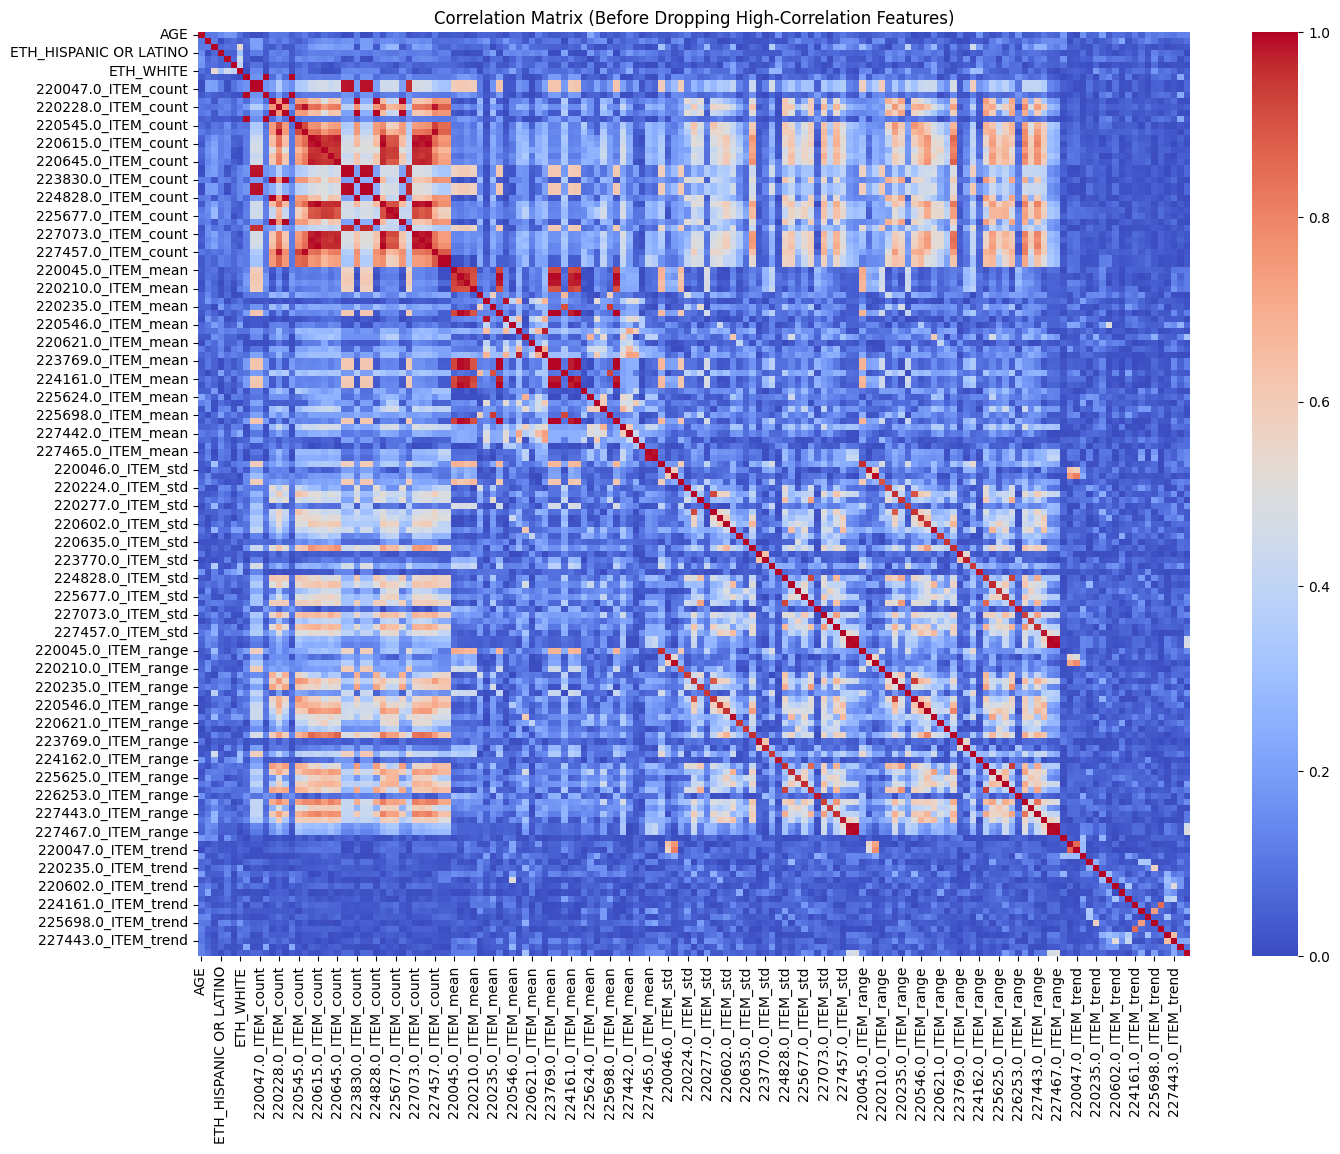

In [454]:
X = df_selected.drop(columns=non_numerical_feature_cols)

corr_matrix = X.corr().abs()

print("Generating heatmap for features before correlation-based removal...")

plt.figure(figsize=(16, 12))  # Adjust size as needed for readability
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False) # annot=True can be used for smaller matrices
plt.title('Correlation Matrix (Before Dropping High-Correlation Features)')
plt.show()


In [455]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print(f"Number of features to drop due to high correlation: {len(to_drop)}")
print("Columns being dropped:", to_drop)


Number of features to drop due to high correlation: 74
Columns being dropped: ['220047.0_ITEM_count', '220210.0_ITEM_count', '220235.0_ITEM_count', '220277.0_ITEM_count', '220545.0_ITEM_count', '220546.0_ITEM_count', '220615.0_ITEM_count', '220621.0_ITEM_count', '220635.0_ITEM_count', '220645.0_ITEM_count', '223769.0_ITEM_count', '223770.0_ITEM_count', '223830.0_ITEM_count', '224161.0_ITEM_count', '224162.0_ITEM_count', '224828.0_ITEM_count', '225624.0_ITEM_count', '225625.0_ITEM_count', '225677.0_ITEM_count', '225698.0_ITEM_count', '226253.0_ITEM_count', '227073.0_ITEM_count', '227442.0_ITEM_count', '227443.0_ITEM_count', '227457.0_ITEM_count', '227467.0_ITEM_count', '220046.0_ITEM_mean', '220047.0_ITEM_mean', '220210.0_ITEM_mean', '220277.0_ITEM_mean', '220545.0_ITEM_mean', '220645.0_ITEM_mean', '223769.0_ITEM_mean', '223770.0_ITEM_mean', '223830.0_ITEM_mean', '224161.0_ITEM_mean', '224162.0_ITEM_mean', '225698.0_ITEM_mean', '226253.0_ITEM_mean', '227467.0_ITEM_mean', '220545.0_ITEM_

In [456]:
df_final_selected = df_selected.drop(columns=to_drop)

print(f"\nFinal number of features: {df_final_selected.shape[1] - len(non_numerical_feature_cols)}")
print("Shape of the final DataFrame:", df_final_selected.shape)
print("\nFirst 5 rows of the final DataFrame:")
df_final_selected.head()


Final number of features: 79
Shape of the final DataFrame: (140, 83)

First 5 rows of the final DataFrame:


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,LOG_LOS,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,...,220645.0_ITEM_trend,224161.0_ITEM_trend,224828.0_ITEM_trend,225624.0_ITEM_trend,225698.0_ITEM_trend,226253.0_ITEM_trend,227073.0_ITEM_trend,227443.0_ITEM_trend,227457.0_ITEM_trend,227465.0_ITEM_trend
0,87980,110615,243965,0.109661,65.748118,1,False,False,False,False,...,-0.305732,-5.950044e-16,0.000000,-0.382166,0.000000,-2.999918e-15,-0.152866,-0.076433,0.305732,0.000000
1,94937,162005,280084,0.133831,68.389459,1,False,False,False,True,...,0.010028,4.331593e-03,-0.118915,-0.038307,-0.075559,-2.505015e-19,-0.012288,0.003193,-0.330480,-0.002616
2,63941,126602,270748,0.139414,74.917864,0,False,False,False,True,...,0.000000,3.165939e-01,0.000000,0.000000,0.000000,1.559136e-15,0.000000,0.000000,0.000000,0.000000
3,43484,172124,210014,0.224982,76.251882,1,True,False,False,False,...,-0.021909,-1.405424e-02,0.040226,-0.013226,0.045344,1.473157e-17,-0.016617,0.034211,0.077485,0.000943
4,26855,112153,200612,0.253944,66.260096,0,False,False,False,True,...,0.000000,-5.988390e-02,0.000000,0.000000,0.000000,-1.046364e-15,0.000000,0.000000,0.000000,0.000000


- Isolate Features (X): We start with df_variance_selected, the DataFrame that has already been filtered for low variance. We create X which contains only the feature columns from this set.
- Correlation Matrix: We compute the correlation matrix for X and take the absolute value, as we're interested in the strength of the correlation, not its direction (positive or negative).
- Upper Triangle: The line np.triu(...) creates a mask for the upper triangle of the matrix (everything above the main diagonal). We do this because a correlation matrix is symmetrical (corr(A,B) is the same as corr(B,A)), and we only need to check each pair of features once to avoid redundancy.
- Find Columns to Drop: We iterate through the columns of our upper-triangle view. If any value in a column is greater than our threshold (0.9), we add that column's name to our to_drop list. This effectively keeps one feature from each highly correlated pair and flags the other for removal.
- Create Final DataFrame: We drop the columns in the to_drop list from df_variance_selected to produce our final, cleaned dataset df_final_selected.


Generating heatmap for the final set of features...


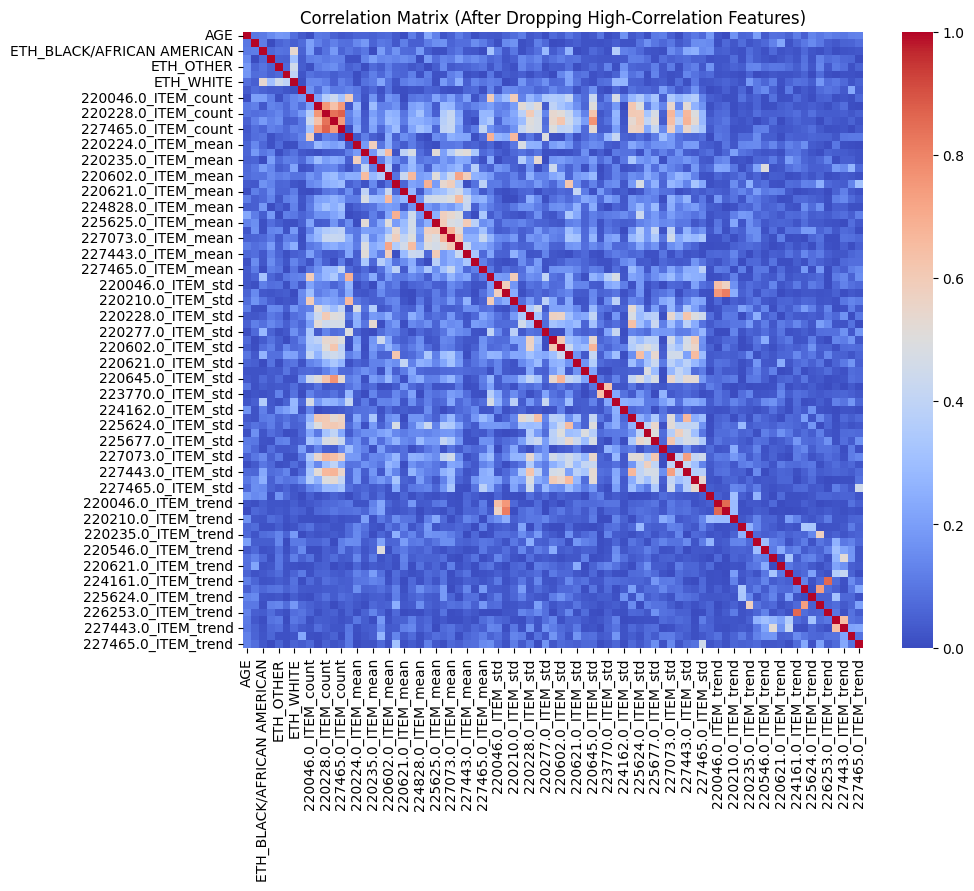

In [457]:
final_features = df_final_selected.drop(columns=non_numerical_feature_cols)

# Calculate the new correlation matrix
final_corr_matrix = final_features.corr().abs()

print("\nGenerating heatmap for the final set of features...")

plt.figure(figsize=(10, 8)) # Can be a bit smaller as there are fewer features
sns.heatmap(final_corr_matrix, cmap='coolwarm', annot=False, vmin=0, vmax=1)
plt.title('Correlation Matrix (After Dropping High-Correlation Features)')
plt.show()


Training the XGBoost model...
Model training complete.

Calculating permutation importance on the validation set...

Top Feature Importances:
                feature  importance_rmse_drop  relative_contribution_%
14   220224.0_ITEM_mean              0.003782                25.987820
28   227443.0_ITEM_mean              0.003574                24.558653
53    226253.0_ITEM_std              0.002965                20.372763
24   225625.0_ITEM_mean              0.001459                10.027591
26   227073.0_ITEM_mean              0.001083                 7.439719
10  220228.0_ITEM_count              0.000812                 5.579226
42    220621.0_ITEM_std              0.000325                 2.234354
41    220615.0_ITEM_std              0.000290                 1.995585
27   227442.0_ITEM_mean              0.000263                 1.804288


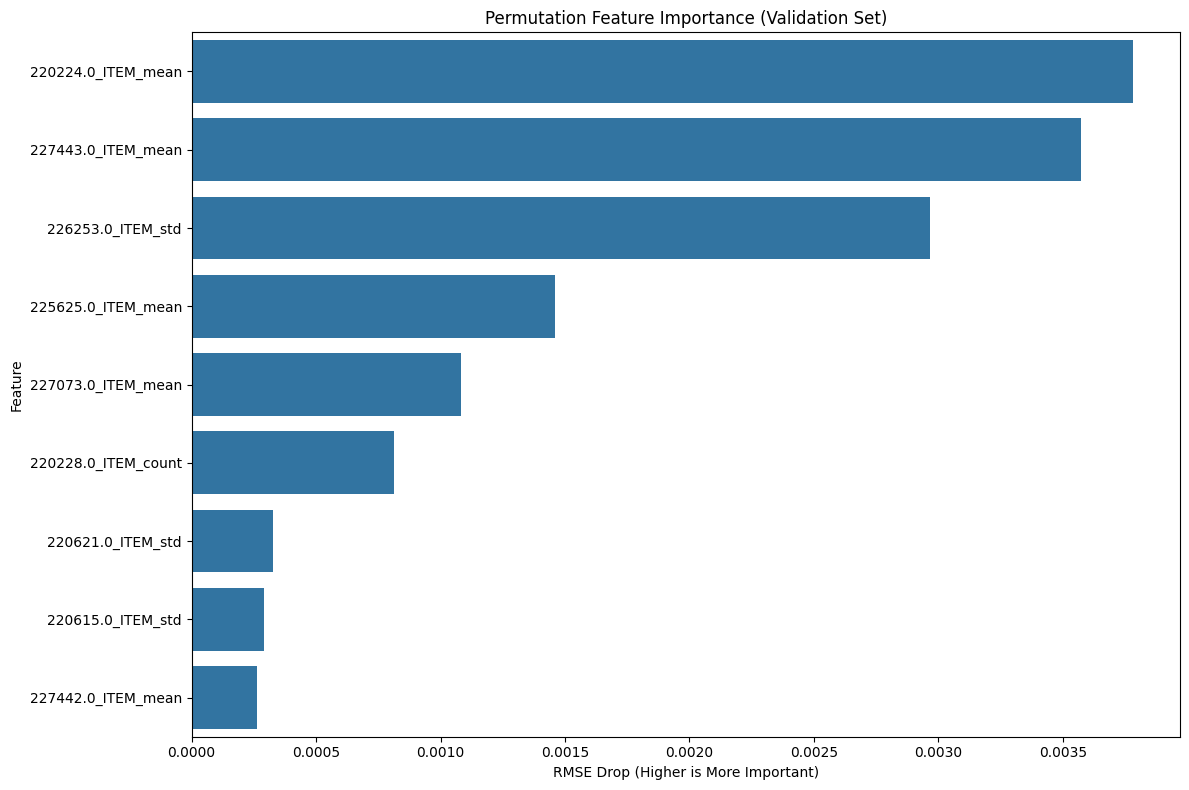


Number of features contributing >= 1%: 9
Final selected features:
['220224.0_ITEM_mean', '227443.0_ITEM_mean', '226253.0_ITEM_std', '225625.0_ITEM_mean', '227073.0_ITEM_mean', '220228.0_ITEM_count', '220621.0_ITEM_std', '220615.0_ITEM_std', '227442.0_ITEM_mean']

Shape of final training features: (105, 9)
Shape of final validation features: (35, 9)

Shape of the final complete DataFrame: (140, 13)

First 5 rows of the final complete DataFrame:
   SUBJECT_ID  HADM_ID  ICUSTAY_ID   LOG_LOS  220224.0_ITEM_mean  \
0       87980   110615      243965  0.109661            0.000000   
1       94937   162005      280084  0.133831          283.142857   
2       63941   126602      270748  0.139414            0.000000   
3       43484   172124      210014  0.224982          142.600000   
4       26855   112153      200612  0.253944            0.000000   

   227443.0_ITEM_mean  226253.0_ITEM_std  225625.0_ITEM_mean  \
0           23.500000                0.0            9.350000   
1           23

In [467]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# --- Pre-computation ---
# This script assumes a DataFrame 'df_final_selected' exists from the previous
# feature selection steps (variance and correlation filtering).
# It also assumes the target variable 'LOG_LOS' is a column in that DataFrame.

# 1. Prepare your data for modeling
# Define the target variable and any columns that are not features.
# Add any other non-feature columns here (e.g., original 'los', other targets)

# Create the feature matrix X and the target vector y
# Ensure all columns in non_feature_cols actually exist in the DataFrame to avoid errors
existing_non_feature_cols = [col for col in non_numerical_feature_cols if col in df_final_selected.columns]
X = df_final_selected.drop(columns=existing_non_feature_cols)
y = df_final_selected['LOG_LOS']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# --- Step 1: Train the XGBoost Model ---
# Use the specified parameters and early stopping to find the optimal number of trees.
print("Training the XGBoost model...")
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1, # Use all available cores
    eval_metric="mae",
    early_stopping_rounds=50,
 

)

model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          # Use 'rmse' here as it's a standard eval_metric for XGBoost
          verbose=False)

print("Model training complete.")


# --- Step 2: Calculate Permutation Importance ---
# This is performed on the validation set to see which features the model
# relies on for making predictions on unseen data.
print("\nCalculating permutation importance on the validation set...")

# Use 'neg_root_mean_squared_error' as the scorer, which is the scikit-learn
# equivalent of RMSE. It will be negative because scorers assume higher is better.
result = permutation_importance(
    model, 
    X_val, 
    y_val, 
    scoring='neg_root_mean_squared_error', 
    n_repeats=10, 
    random_state=42
)

# Get the mean importance values from the result object
importances = result.importances_mean


# --- Step 3: Process and Filter the Importance Results ---

# Create a DataFrame for easier analysis
df_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance_rmse_drop': importances
})

# Filter out features with non-positive importance (they don't help the model)
df_importances = df_importances[df_importances['importance_rmse_drop'] > 0]

# Calculate the total sum of positive importances
total_importance = df_importances['importance_rmse_drop'].sum()

# Calculate relative contribution for each feature
df_importances['relative_contribution_%'] = 100 * df_importances['importance_rmse_drop'] / total_importance

# Sort the DataFrame for better visualization
df_importances = df_importances.sort_values(by='importance_rmse_drop', ascending=False)

print("\nTop Feature Importances:")
print(df_importances)


# --- Step 4: Visualize the Importances ---

plt.figure(figsize=(12, 8))
sns.barplot(x='importance_rmse_drop', y='feature', data=df_importances)
plt.title('Permutation Feature Importance (Validation Set)')
plt.xlabel('RMSE Drop (Higher is More Important)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# --- Step 5: Create Final DataFrames with Selected Features ---

# Keep only features contributing >= 1% to the total RMSE drop
selected_features = df_importances[df_importances['relative_contribution_%'] >= 1]['feature'].tolist()

print(f"\nNumber of features contributing >= 1%: {len(selected_features)}")
print("Final selected features:")
print(selected_features)

# Create final training and validation sets with only the selected features
X_train_final = X_train[selected_features]
X_val_final = X_val[selected_features]

print(f"\nShape of final training features: {X_train_final.shape}")
print(f"Shape of final validation features: {X_val_final.shape}")

# Create a final, complete DataFrame with selected features plus identifiers and target
final_cols_to_keep = existing_non_feature_cols + selected_features
df_perm_selected = df_final_selected[final_cols_to_keep]

print(f"\nShape of the final complete DataFrame: {df_perm_selected.shape}")
print("\nFirst 5 rows of the final complete DataFrame:")
print(df_perm_selected.head())


In [478]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

X = df_final_selected.drop(columns=['SUBJECT_ID','HADM_ID','ICUSTAY_ID', 'LOG_LOS'])
y = df_final_selected['LOG_LOS']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

from sklearn.model_selection import GridSearchCV, KFold

params = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100, 200, 300]
}
xgb = XGBRegressor(random_state = 42
                   ,eval_metric = 'mae')

cv_splitter = KFold(n_splits=5, shuffle=True, random_state=42)

model = GridSearchCV(estimator = xgb, param_grid=params, cv=cv_splitter, scoring='neg_mean_absolute_error', n_jobs=-1)
model.fit(X_train, y_train)
print("Best MAE:", np.exp(-model.best_score_))


# Train
# model = XGBRegressor()
# model.fit(X_train, y_train)

# # Evaluate
# from sklearn.metrics import mean_absolute_error
# y_pred = model.predict(X_test)
# print(f"MAE: {mean_absolute_error(np.exp(y_test), np.exp(y_pred)):.2f}")
best_log_mae = -model.best_score_

print(f"The best cross-validated MAE on the log-transformed data was: {best_log_mae:.4f}")

best_model = model.best_estimator_

# 2. Use this best model to predict on the unseen test set
predictions_log = best_model.predict(X_test)

# 3. Convert BOTH the predictions and the true test labels back to days
#    (This assumes y_test is also in log-scale, which it should be)
predictions_days = np.exp(predictions_log)
y_test_days = np.exp(y_test)

from sklearn.metrics import mean_absolute_error

# 4. NOW, calculate the MAE on the day-scale values
final_mae_in_days = mean_absolute_error(y_test_days, predictions_days)

print(f"Best parameters found: {model.best_params_}")
print(f"Final MAE on the hold-out test set: {final_mae_in_days:.4f} days")

Best MAE: 2.156435737164564
The best cross-validated MAE on the log-transformed data was: 0.7685
Best parameters found: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Final MAE on the hold-out test set: 8.2754 days


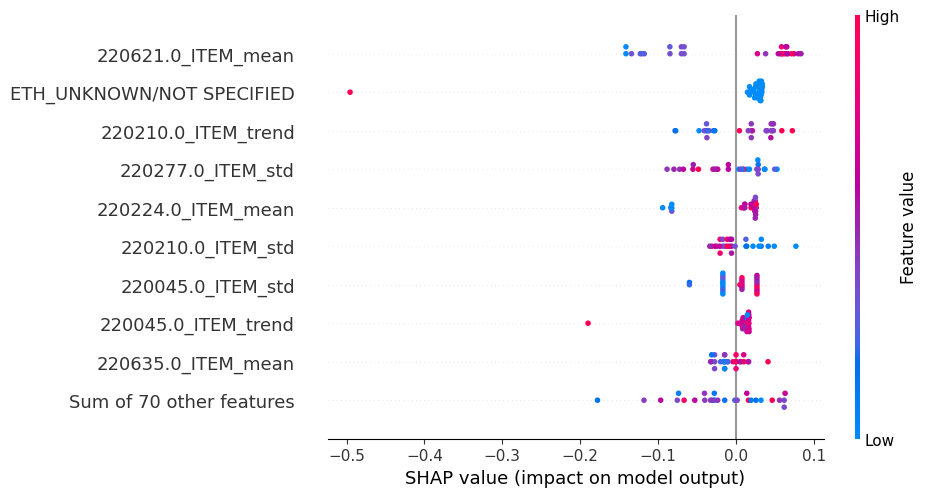

In [464]:
import shap
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

In [465]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# features = ['GENDER',
#        'AGE', 'ADMITIME', 'ETH_BLACK/AFRICAN AMERICAN',
#        'ETH_HISPANIC OR LATINO', 'ETH_OTHER', 'ETH_UNKNOWN/NOT SPECIFIED',
#        'ETH_WHITE', 'ITEMID', 'VALUENUM', 'NORMTIME']
# df_merged_with_chartevents = df_merged_with_chartevents.dropna()

# X = df_merged_with_chartevents[features]
# # X = X.dropna()
# y = df_merged_with_chartevents['LOG_LOS']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, # 20% for testing
    random_state=42 # for reproducible results
)

gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# 2. Train the model on the training data
gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [466]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Make predictions on the test data
y_pred = gbr.predict(X_test)

# If your target was LOG_LOS, you must convert predictions back to the original scale
y_pred_original_scale = np.expm1(y_pred)
y_test_original_scale = np.expm1(y_test)

# 2. Calculate metrics
mae = mean_absolute_error(y_test_original_scale, y_pred_original_scale)
mse = mean_squared_error(y_test_original_scale, y_pred_original_scale)
r2 = r2_score(y_test_original_scale, y_pred_original_scale)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2 Score): {r2:.2f}")

Mean Absolute Error (MAE): 9.43
Mean Squared Error (MSE): 150.61
R-squared (R2 Score): -0.07
